# Self-Driving Car: Finding Lane Lines

### Daniel Wolf

### November 2016


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


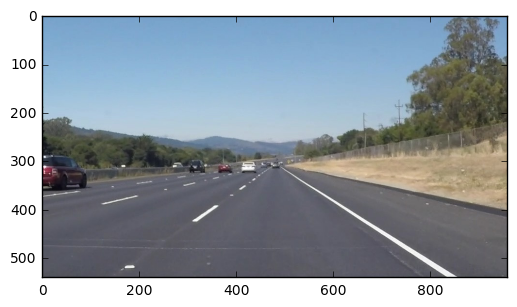

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

### Define Helper Functions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, y_min, useclass, color=[255, 0, 0], thickness=10):
    """
    This function extrapolates and draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    r_slope = []
    l_slope = []
    l_line_x = []
    l_line_y = []
    r_line_x = []
    r_line_y = []
    y_max = image.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < -0.4:
                l_slope.append(slope)
                l_line_x.append(x1)
                l_line_x.append(x2)
                l_line_y.append(y1)
                l_line_y.append(y2)
            if slope > 0.4:
                r_slope.append(slope)
                r_line_x.append(x1)
                r_line_x.append(x2)
                r_line_y.append(y1)
                r_line_y.append(y2)
    
    # ERROR CHECKING
    # If no reliable lines are found, use the slopes and lines from the prior frame
    # If reliable lanes are found, update the lines class with the latest lines
    # Only checked if running the pipeline on the video (as opposed to individual test images)
    if useclass:
        if not l_slope:
            l_slope = line_class.l_slope
            l_line_x = line_class.l_line_x
            l_line_y = line_class.l_line_y
        else:
            line_class.l_slope = l_slope
            line_class.l_line_x = l_line_x
            line_class.l_line_y = l_line_y
        if not r_slope:
            r_slope = line_class.r_slope
            r_line_x = line_class.r_line_x
            r_line_y = line_class.r_line_y
        else:
            line_class.r_slope = r_slope
            line_class.r_line_x = r_line_x
            line_class.r_line_y = r_line_y
    
    # Create the lines using the arrays defined above
    left_slope = np.mean(l_slope)
    left_x = np.mean(l_line_x)
    left_y = np.mean(l_line_y)
    
    right_slope = np.mean(r_slope)
    right_x = np.mean(r_line_x)
    right_y = np.mean(r_line_y)
    
    l_y_int = left_y - left_slope * left_x
    r_y_int = right_y - right_slope * right_x
    
    l_x1 = int((y_min - l_y_int) / left_slope)
    l_x2 = int((y_max - l_y_int) / left_slope)
    r_x1 = int((y_min - r_y_int) / right_slope)
    r_x2 = int((y_max - r_y_int) / right_slope)
    
    left_line = tuple(((l_x1, y_min), (l_x2, y_max)))
    right_line = tuple(((r_x1, y_min), (r_x2, y_max)))
    
    cv2.line(img, left_line[0], left_line[1], color, thickness)
    cv2.line(img, right_line[0], right_line[1], color, thickness)
    
    return img
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y_min):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color=[255, 0, 0], thickness=5)
            
#    print(lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Define Pipeline

In [4]:
def process_image(image, useclass=False):
    
    # Read in the image and convert to grayscale
    gray = grayscale(image)
    
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3 # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Vertices method adapted from Confluence post by Vivek Yadav post
    fac = 1.65
    x_dim = np.shape(image)[1]
    y_dim = np.shape(image)[0]
    vertices = np.array([[(0,y_dim), (x_dim,y_dim), (x_dim/2+10,y_dim/fac),
                          (x_dim/2-10,y_dim/fac)]], dtype = np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    # Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/360 # angular resolution in radians of the Hough grid
    threshold = 75 #15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 80 # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected image
    line_img, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, int(y_dim/fac))
    
    draw_img = draw_lines(np.zeros((*masked_edges.shape, 3), dtype=np.uint8), lines, int(y_dim/fac), useclass)
    
    # Iterate over the output "lines" and draw lines on a blank image
    result = weighted_img(draw_img, image, α=0.8, β=1., λ=0.)
    
    # If testing on individual images as opposed to video, return example images from throughout the pipeline
    if not useclass:
        return blur_gray, edges, line_img, result
    else:
        return result

### Test on Images

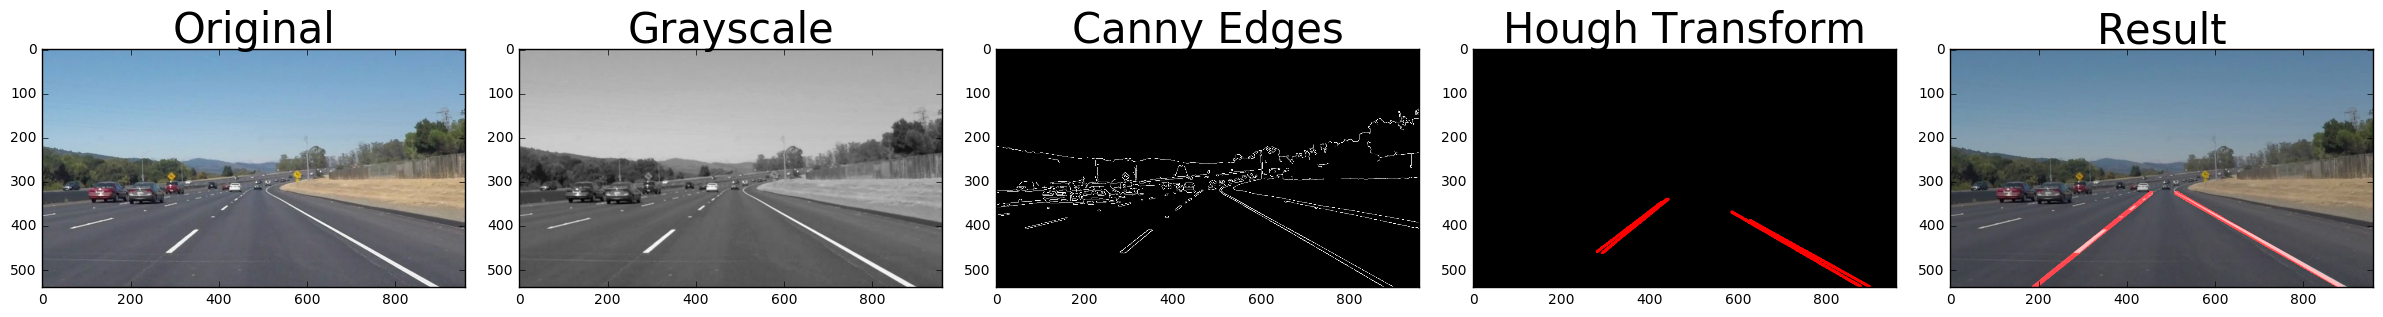

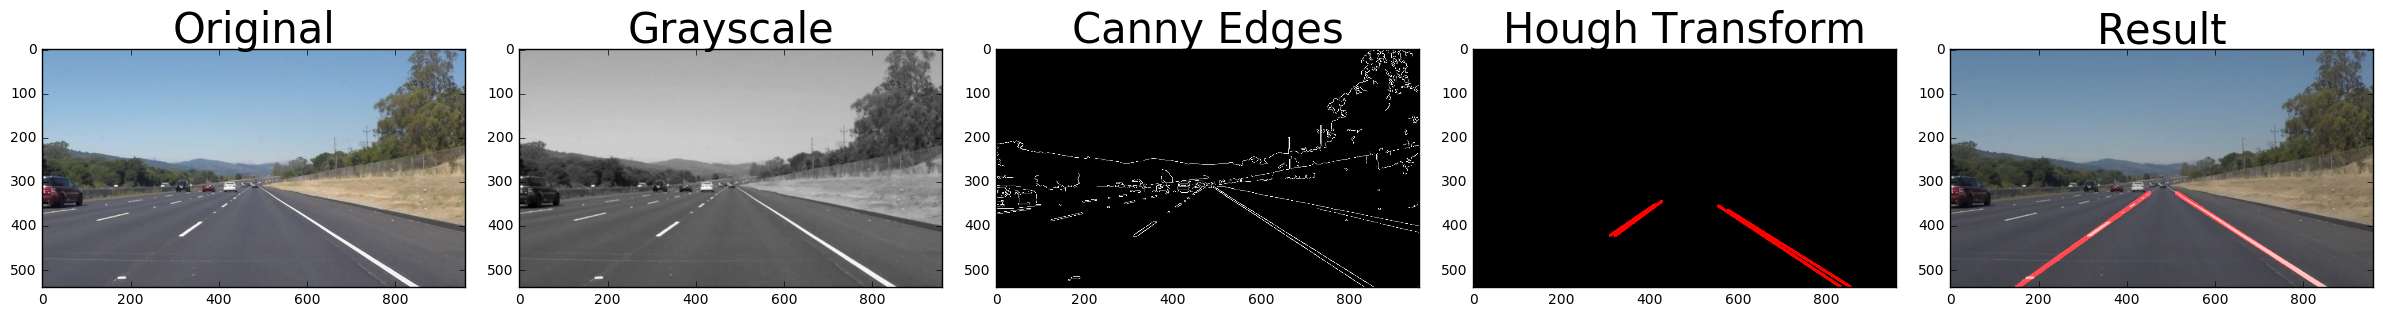

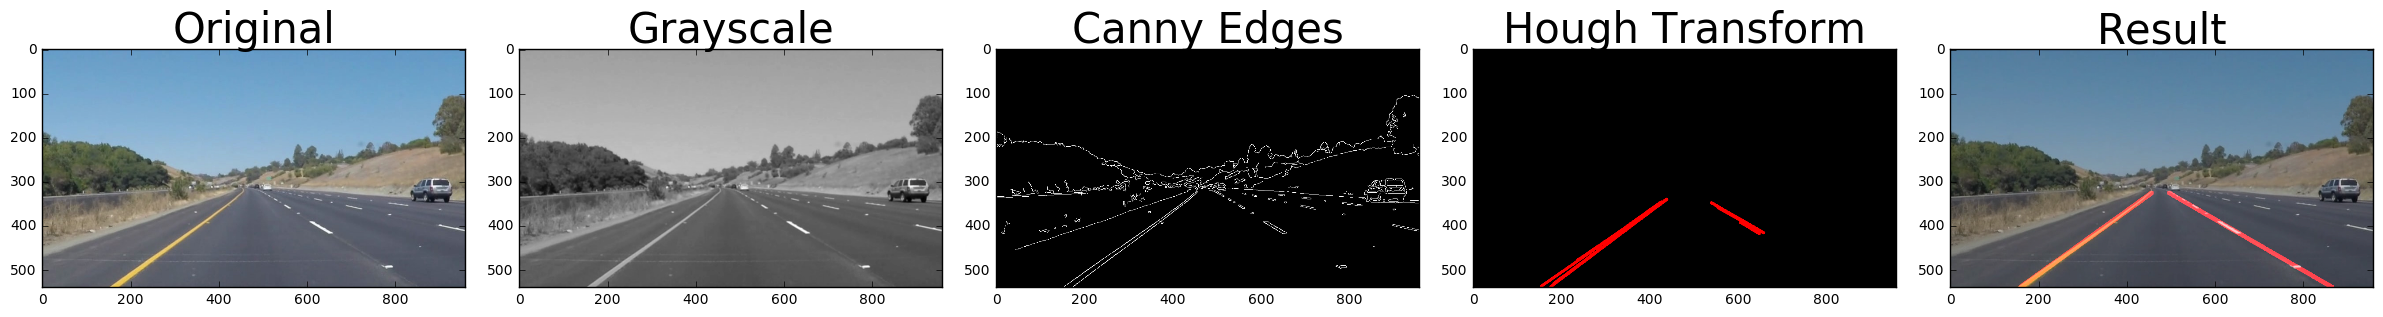

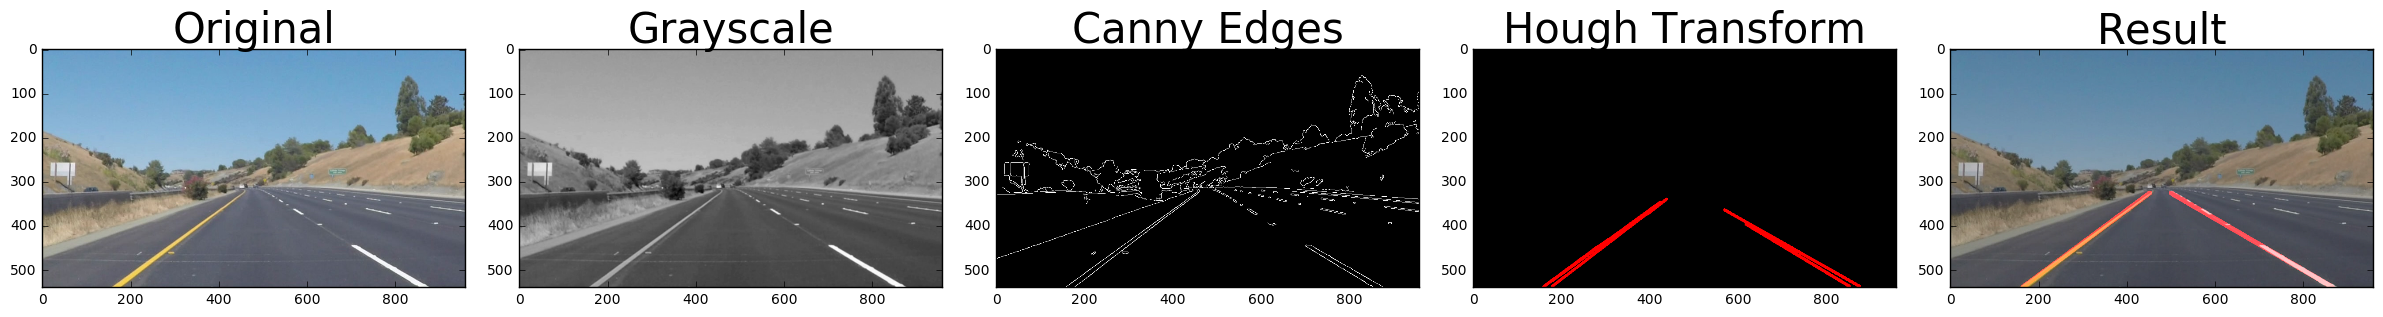

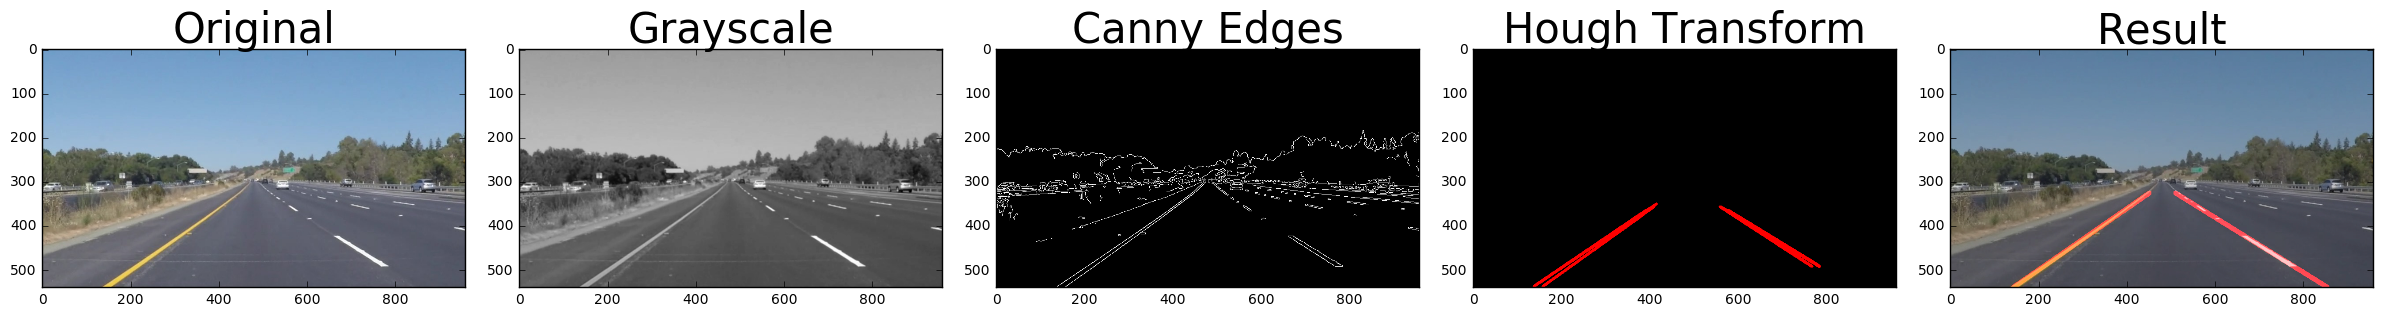

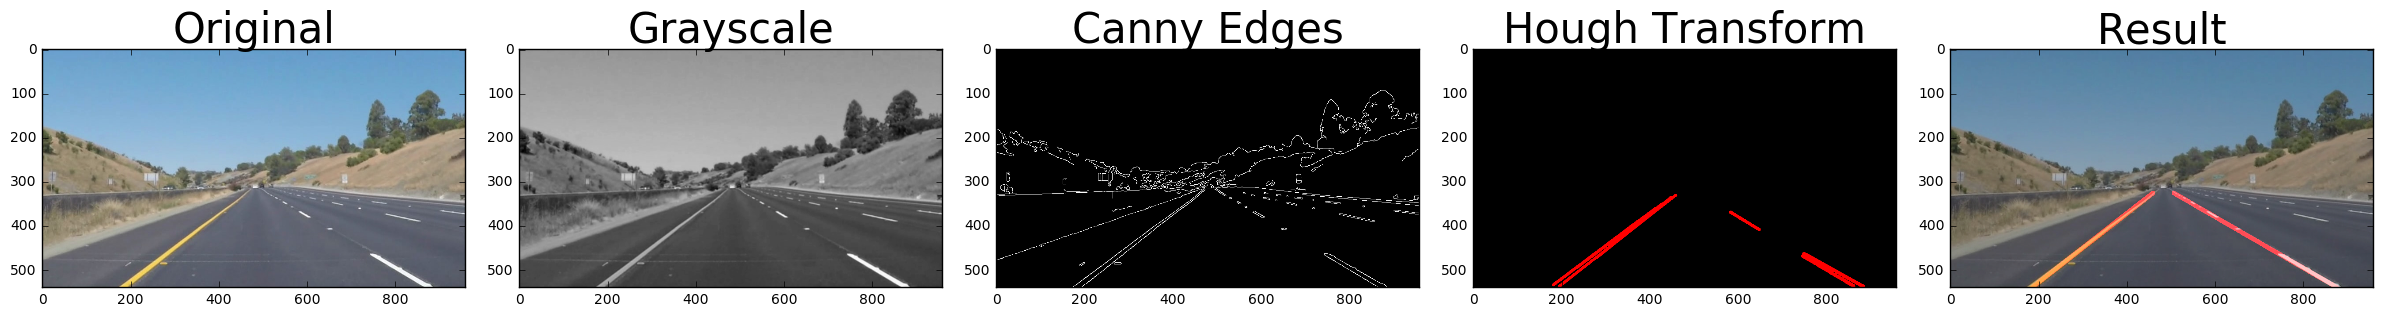

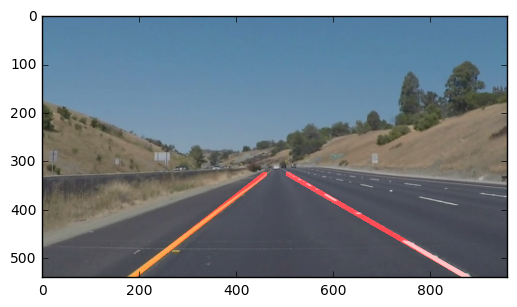

In [5]:
import glob
images = glob.glob('test_images/*.jpg')

for fname in images:
    image = mpimg.imread(fname)
    blur_gray, edges, line_img, result = process_image(image)
    
        # Visualize the results
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original', fontsize=30)
    ax1.imshow(image)
    ax2.set_title('Grayscale', fontsize=30)
    ax2.imshow(blur_gray, cmap='gray')
    ax3.set_title('Canny Edges', fontsize=30)
    ax3.imshow(edges, cmap='gray')
    ax4.set_title('Hough Transform', fontsize=30)
    ax4.imshow(line_img)
    ax5.set_title('Result', fontsize=30)
    ax5.imshow(result)
    plt.show()

    
plt.imshow(result)
plt.show()

### Test on Video

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # check for first frame of the video
        self.first = True
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.allx = None
        self.l_slope = []
        self.l_line_x = []
        self.l_line_y = []
        self.r_slope = []
        self.r_line_x = []
        self.r_line_y = []
        

In [8]:
# Set up the pipeline so that the Line class is enabled for reliability and error checking
def pipeline(image):
    
    return process_image(image, useclass=True)
    

In [9]:
# Initialize lines
line_class = Line()

# Process the video
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(pipeline) # Send each frame to process_image()
%time white_clip.write_videofile('yellow.mp4', audio=False)


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:07<00:00, 96.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 7.31 s
